In [1]:
'''
1. Linear approximate exon distribution peak VS intron density 
2. Fit gamma to exon length distribution
refined ES parameter parsing
'''
## use ipython parallel programming 
from IPython.parallel import Client
rc = Client()
dview = rc[:]


import pandas as pd; dview.execute("import pandas as pd")
import numpy as np; dview.execute("import numpy as np")
from scipy import stats


import matplotlib.pylab as plt
import os
%matplotlib inline


# The path where all the GeneMark-ES 4th run models located
modelFilePath = "/home/richard/largeDataSet/ES_Run_modfileAug2015/"
modelFileNames = os.listdir(modelFilePath)

# full data
fulldata = pd.read_csv("../1_DataSmall/fullTableInfoGff3GffRNAESwithDensity20150829.csv", index_col='shortName' )
# add Pneji1 to fulldata for passing ES run
fulldata.loc['Pneji1','ES'] = 'pass'
fulldata.to_csv("../1_DataSmall/fullTableInfoGff3GffRNAESwithDensity20150909.csv",index = None)

class ESParamParse():
    """Take in 4th run of model file as text and extract info"""
    _DISTR_TYPE= {
        'INITIAL'  :('$INITIAL_DISTR', range(3,10001)),
        'EXON'     :('$EXON_DISTR',range(3,10001)),
        'TERMINAL' : ('$TERMINAL_DISTR', range(3,10001)),
        'SINGLE'   :('$SINGLE_DISTR', range(300,10000)),
        'INTRON'   :('$INTRON_DISTR',range(20,3001)),
        'BP_ACC'   :('$BP_ACC_DISTR',range(2,41)),
        'DON_BP'   :('$DON_BP_DISTR',range(5,3001))
    }
    
    def __init__(self, filename):
        self.f = open(filename)
    def close(self):
        '''close file connection'''
        self.f.close()
        
    def maxPosition(self, distrType):
        '''
        return the position with the highest probability
        '''
        # decompose the distrbutionType varibable to distribution type/tag and min_max length range
        TAG, RANGE = self._DISTR_TYPE[distrType]
        # accqure the max length signal
        LENGTH = RANGE[-1]

        # capture length distribution
        lengthData = []
        switch = False
        for line in self.f:
            if switch:
                lengthData.append(line)
            if TAG in line:
                switch = True
            if switch and "{}\t".format(LENGTH) in line:
                switch = False
                break
        lengthData = map(lambda line: line.rstrip().split("\t"), lengthData)
        positionProbabilityPair = map(lambda (a,b): (int(a), float(b)), lengthData)
        df = pd.DataFrame(positionProbabilityPair, columns=['position','probability']) 
        # return position of peak probability
        return df.position[np.argmax(df.probability)]
    
    def getLengthDistribution(self, distrType = 'EXON', probAcc = 0.95):

            '''
            input: Optional
            probAcc, probability accumulation, default = 0.9
            distrType, one of the six length distribution type

            return: dataframe with probability and their position(as two columns) that take up 0.95 probability(default)

            '''
            # decompose the distrbutionType varibable to distribution type/tag and min_max length range
            TAG, RANGE = self._DISTR_TYPE[distrType]
            # accqure the max length signal
            LENGTH = RANGE[-1]

            # capture length distribution
            lengthData = []
            switch = False
            for line in self.f:
                if switch:
                    lengthData.append(line)
                if TAG in line:
                    switch = True
                if switch and "{}\t".format(LENGTH) in line:
                    switch = False
                    break
            lengthData = map(lambda line: line.rstrip().split("\t"), lengthData)
            positionProbabilityPair = map(lambda (a,b): (int(a), float(b)), lengthData)

            df = pd.DataFrame(positionProbabilityPair, columns=['position','probability']) 

            #sort probability in reverse order, capture distribution that take up to probAcc
            df.sort_index(axis = 0, ascending = False, by = ['probability'], inplace = True)
            df['accProb'] = df.probability.cumsum()
            idx  = df.accProb < probAcc
            df_sub = df[idx].copy()
            #sort index to original order, output data frame
            df_sub.sort_index(axis = 0, by = ['position'], inplace = True)
            return df_sub[['position','probability']]

    
dview.push({'ESParamParse':ESParamParse,'modelFilePath':modelFilePath,'modelFileNames':modelFileNames})

## create data frame that collect all the peak probabilities
shortNames = map(lambda x: x.split(".")[0], modelFileNames)
dfPeakProbs = pd.DataFrame({'shortName': shortNames})
dfPeakProbs.index = shortNames

In [2]:
## First of all, find linear relation between exon peak probability and intron density
exonPeakProbMap = dview.map(lambda modelName: ESParamParse(modelFilePath+modelName).maxPosition('EXON'), modelFileNames)
exonPeakProbReduce = exonPeakProbMap.get()
dfPeakProbs['exonPeakPosition'] = exonPeakProbReduce
fulldata[['intronDensityGff3','intronDensityGff']].apply(pd.isnull).sum(0) # we saw Gff have more intron density data

intronDensityGff3    142
intronDensityGff      25
dtype: int64

In [3]:
# left join to add intron density column
dfPeakProbs = dfPeakProbs.join(fulldata['intronDensityGff'])

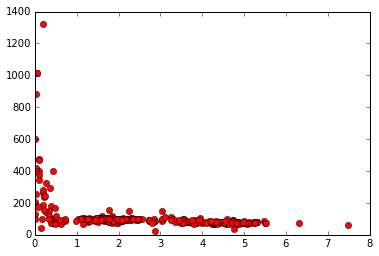

In [4]:
# with intron density < 1 species included, they are probably noises
plt.plot(dfPeakProbs.intronDensityGff,dfPeakProbs.exonPeakPosition,'ro')

In [5]:
# create index with intron density > 1
idx = dfPeakProbs.intronDensityGff > 1
dfPeakProbs = dfPeakProbs[idx]

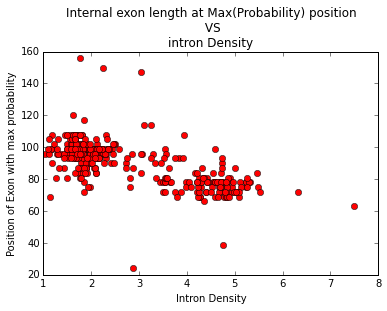

In [6]:
#visualize exon VS intron density
plt.plot(dfPeakProbs.intronDensityGff,dfPeakProbs.exonPeakPosition,'ro')
plt.xlabel("Intron Density")
plt.ylabel("Position of Exon with max probability")
# plt.ylim([20,200])
plt.title("Internal exon length at Max(Probability) position \n VS \nintron Density")

In [7]:
######################
########   linear fitting: x = intron density, y = exon length
slope, intercept, r_value, p_value, std_err = \
        stats.linregress(dfPeakProbs.intronDensityGff,dfPeakProbs.exonPeakPosition)

In [8]:
## generate two points on the regression line and plot it on the previous graph
x_vec = (1,7)
y_vec = map(lambda x: intercept + x * slope, x_vec)

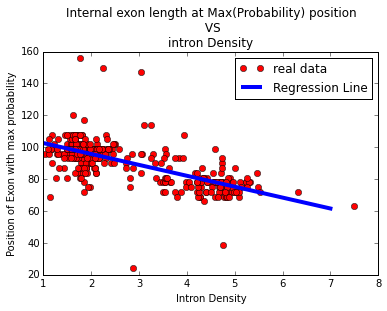

In [9]:
#visualize exon VS intron density with regression line
plt.plot(dfPeakProbs.intronDensityGff,dfPeakProbs.exonPeakPosition,'ro', label = "real data")
plt.plot(x_vec,y_vec,"b-",lw = 4,label = 'Regression Line')
plt.xlabel("Intron Density")
plt.ylabel("Position of Exon with max probability")
plt.legend()
# plt.ylim([20,200])
plt.title("Internal exon length at Max(Probability) position \n VS \nintron Density")

In [10]:
### For each intron density we can 
##  1. find the related peak point, that 
##  2. build gamma distribution based on peak probability location and intron density

In [11]:
## how to fit a gamma distribution
# set sample size, for example 100000
# time each probability with sample size and take the integer value
# fit gamma distrbution with the lengths generated

In [12]:
## save compare png to file
fittingPath = "/home/richard/research/1_DataSmall/Plots/gammaFitting/exon/"

In [13]:
test1 = ESParamParse(modelFilePath+'{}.ES_C_4.mod'.format('Schpo1'))
test1.maxPosition("EXON")

96

In [14]:
def fit_and_compare(shortName, accProb = .88, distriType = 'EXON',size = 10000, demo = True, exon_type = 'Internal'):
    test1 = ESParamParse(modelFilePath+'{}.ES_C_4.mod'.format(shortName))
    df_test = test1.getLengthDistribution(distriType,accProb)
    
    
    # generate sample points for gamma to fit
    counts = map(lambda n: int(round(n)),df_test.probability*size)
    df_test['counts'] = counts
    
    # multicore version
    dview.push({'df_test':df_test})
    lengths_map = dview.map(lambda i: df_test.counts[i]*
                  [df_test.position[i]],
                  df_test.index)
    lengths_reduce = lengths_map.get()
    lengths = reduce(lambda a,b : a+b,lengths_reduce)
    
    
    ## gamma fitting
    shape,loc,scale = stats.gamma.fit(lengths)
    print "shape = {}, scale = {}".format(shape,scale)
    print "max position: ", ESParamParse(modelFilePath+'{}.ES_C_4.mod'.format(shortName)).maxPosition(distriType)
    
    plt.plot(df_test.position,df_test.probability, label = 'ES Exon Length Distribution')
    plt.plot(range(1000),stats.gamma.pdf(range(1000),shape,loc,scale), 'r',label = 'Gamma Fitting')
    longName = " ".join(fulldata.ix[shortName]['longName'].split()[:2])
    gc = fulldata.ix[shortName]['gc']
    intronDensity = fulldata.ix[shortName]['intronDensityGff']
    plt.title("{} {} Exon length distribuiton\ngc: {},  Intron Density: {}".format(longName,exon_type,gc,intronDensity))
    
    plt.legend()
    if demo is False:
        plt.savefig(fittingPath+shortName+'{}Fitting.png'.format(exon_type))
        plt.close()

In [15]:
######## Testing codes

# test1 = ESParamParse(modelFilePath+'Aaoar1.ES_C_4.mod')
test1 = ESParamParse(modelFilePath+'Pneji1.ES_C_4.mod')
# test1 = ESParamParse(modelFilePath+'Schpo1.ES_C_4.mod')
df_test = test1.getLengthDistribution('EXON',.88)

In [16]:
# generate sample points for gamma to fit
size = 100000
counts = map(lambda n: int(round(n)),df_test.probability*size)

In [17]:
df_testWithCount = df_test.copy()
df_testWithCount['counts'] = counts

In [18]:
# single core version
# lengths = reduce(lambda a,b: a+b,map(lambda i: df_testWithCount.counts[i]*
#               [df_testWithCount.position[i]],
#               df_testWithCount.index))

In [19]:
# multicore version
dview.push({'df_testWithCount':df_testWithCount})
lengths_map = dview.map(lambda i: df_testWithCount.counts[i]*
              [df_testWithCount.position[i]],
              df_testWithCount.index)
lengths_reduce = lengths_map.get()
lengths = reduce(lambda a,b : a+b,lengths_reduce)

In [20]:
## gamma fitting
shape,loc,scale = stats.gamma.fit(lengths)

In [21]:
## Updated on Sep17, choose high low mid intron density species
## approximate their 3 exon distributions as gamma and set it as the model species 

In [22]:
## low intron density

shape = 2.01642392721, scale = 86.0644737811
max position:  96


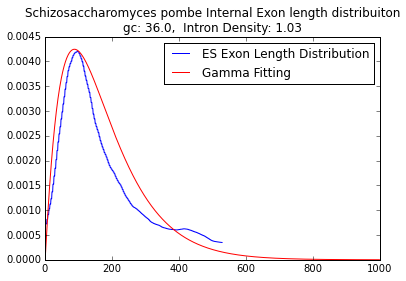

In [23]:
fit_and_compare('Schpo1',accProb = .82, distriType = 'EXON',size = 10000, demo = True, exon_type="Internal")

shape = 1.24809507767, scale = 114.380663114
max position:  42


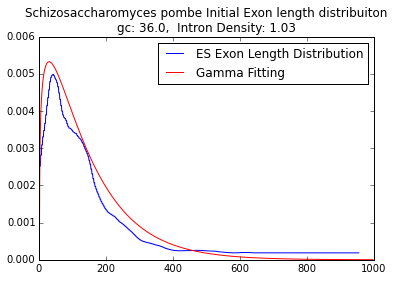

In [24]:
fit_and_compare('Schpo1',accProb = .84, distriType = 'INITIAL',size = 10000, demo = True,exon_type="Initial")

shape = 1.49513799424, scale = 617.638738652
max position:  180


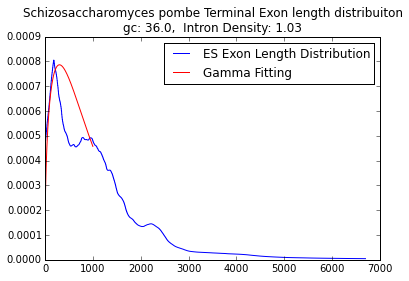

In [25]:
fit_and_compare('Schpo1',accProb = .99, distriType = 'TERMINAL',size = 10000, demo = True,exon_type="Terminal")

In [26]:
_DISTR_TYPE= {
        'INITIAL'  :('$INITIAL_DISTR', range(3,10001)),
        'EXON'     :('$EXON_DISTR',range(3,10001)),
        'TERMINAL' : ('$TERMINAL_DISTR', range(3,10001)),
        'SINGLE'   :('$SINGLE_DISTR', range(300,10000)),
        'INTRON'   :('$INTRON_DISTR',range(20,3001)),
        'BP_ACC'   :('$BP_ACC_DISTR',range(2,41)),
        'DON_BP'   :('$DON_BP_DISTR',range(5,3001))
    }

In [27]:
test = pd.DataFrame({'position':[],'probability':[]})
test.position = range(1000)

In [28]:
## create program that generate emission probs from gamma fitting
def getExonLengthEmissionDistribution(distrType, shape, scale, path,visualCheck = True):
    tag, lengthRange = _DISTR_TYPE[distrType]
    df = pd.DataFrame({'position':[],'probability':[]})
    df.position = lengthRange
    df.probability = stats.gamma.pdf(lengthRange,shape,0,scale)
    
    with open(path,'w') as f:
        f.write(tag+'\n')
        for i in range(df.shape[0]):
            f.write("{}\t{}\n".format(df.position[i],"%.10f"%df.probability[i]))
    if visualCheck is True:
        plt.plot(df.position[:1000],df.probability[:1000])
    print df.tail()

      position   probability
9993      9996  5.120234e-51
9994      9997  5.061616e-51
9995      9998  5.003669e-51
9996      9999  4.946385e-51
9997     10000  4.889757e-51


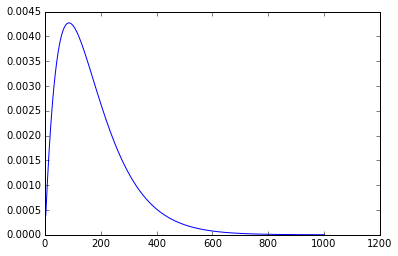

In [29]:
## low density version
filepath = '/home/richard/research/1_DataSmall/heuristic_model_params/exon_length_distribution/lowDensityInternalDistr.txt'
getExonLengthEmissionDistribution('EXON',2.0,86.1,filepath, visualCheck = True)

      position   probability
9993      9996  3.326471e-40
9994      9997  3.297602e-40
9995      9998  3.268985e-40
9996      9999  3.240615e-40
9997     10000  3.212492e-40


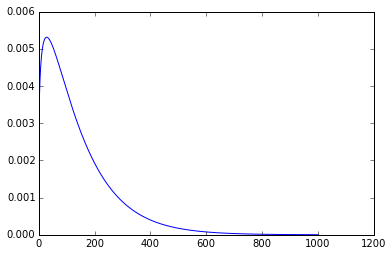

In [30]:
## low density version
filepath = '/home/richard/research/1_DataSmall/heuristic_model_params/exon_length_distribution/lowDensityInitialDistr.txt'
getExonLengthEmissionDistribution('INITIAL',1.25,114.4,filepath, visualCheck = True)

      position   probability
9993      9996  6.873055e-10
9994      9997  6.862278e-10
9995      9998  6.851519e-10
9996      9999  6.840776e-10
9997     10000  6.830050e-10


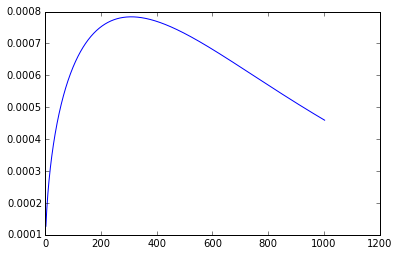

In [31]:
## low density version
filepath = '/home/richard/research/1_DataSmall/heuristic_model_params/exon_length_distribution/lowDensityTerminalDistr.txt'
getExonLengthEmissionDistribution('TERMINAL',1.5,617.6,filepath, visualCheck = True)

shape = 1.41912768595, scale = 215.048733093
max position:  105


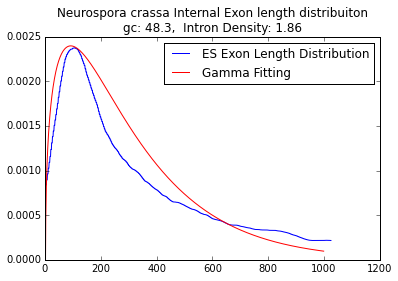

In [32]:
## mid intron density
# EXON part I
fit_and_compare('Neucr2',accProb = .85, distriType = 'EXON',size = 10000, demo = True, exon_type="Internal")

      position   probability
9993      9996  1.566031e-22
9994      9997  1.558827e-22
9995      9998  1.551655e-22
9996      9999  1.544517e-22
9997     10000  1.537411e-22


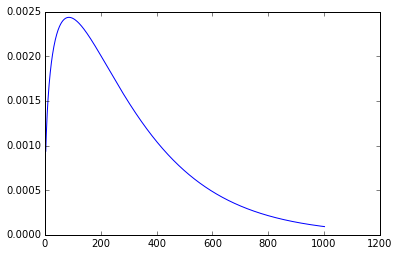

In [33]:
# EXON part II
shape = 1.4
scale = 215.0
filepath = '/home/richard/research/1_DataSmall/heuristic_model_params/exon_length_distribution/midDensityInternalDistr.txt'
getExonLengthEmissionDistribution('EXON',shape,scale,filepath, visualCheck = True)

shape = 1.23090084217, scale = 248.603582355
max position:  63


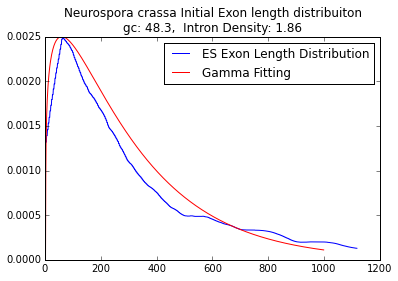

In [34]:
# Initial Exon part I
fit_and_compare('Neucr2',accProb = .88, distriType = 'INITIAL',size = 10000, demo = True, exon_type="Initial")

      position   probability
9993      9996  3.560171e-20
9994      9997  3.545961e-20
9995      9998  3.531807e-20
9996      9999  3.517710e-20
9997     10000  3.503669e-20


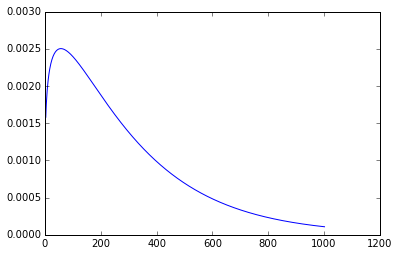

In [35]:
# EXON part II
shape = 1.23
scale = 248.6
filepath = '/home/richard/research/1_DataSmall/heuristic_model_params/exon_length_distribution/midDensityInitialDistr.txt'
getExonLengthEmissionDistribution('INITIAL',shape,scale,filepath, visualCheck = True)

shape = 1.94343627648, scale = 324.13101484
max position:  114


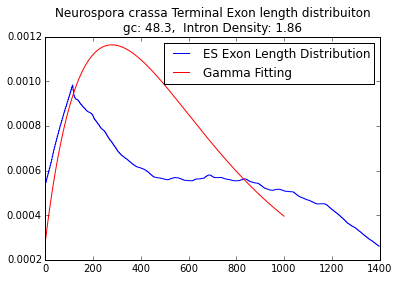

In [36]:
# Initial Exon part I
fit_and_compare('Neucr2',accProb = .8, distriType = 'TERMINAL',size = 10000, demo = True, exon_type="Terminal")

      position   probability
9993      9996  3.198679e-15
9994      9997  3.189125e-15
9995      9998  3.179599e-15
9996      9999  3.170101e-15
9997     10000  3.160632e-15


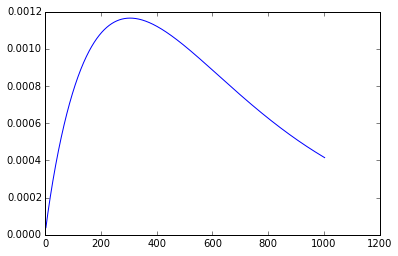

In [37]:
# EXON part II
shape = 1.94
scale = 324.1
filepath = '/home/richard/research/1_DataSmall/heuristic_model_params/exon_length_distribution/midDensityTerminalDistr.txt'
getExonLengthEmissionDistribution('TERMINAL',shape,scale,filepath, visualCheck = True)

In [77]:
#change plot length to 400
LENGTH = 100
def fit_and_compare1(shortName, accProb = .88, distriType = 'EXON',size = 10000, demo = True, exon_type = 'Internal'):
    test1 = ESParamParse(modelFilePath+'{}.ES_C_4.mod'.format(shortName))
    df_test = test1.getLengthDistribution(distriType,accProb)
    
    
    # generate sample points for gamma to fit
    counts = map(lambda n: int(round(n)),df_test.probability*size)
    df_test['counts'] = counts
    
    # multicore version
    dview.push({'df_test':df_test})
    lengths_map = dview.map(lambda i: df_test.counts[i]*
                  [df_test.position[i]],
                  df_test.index)
    lengths_reduce = lengths_map.get()
    lengths = reduce(lambda a,b : a+b,lengths_reduce)
    
    
    ## gamma fitting
    shape,loc,scale = stats.gamma.fit(lengths)
    print "shape = {}, scale = {}".format(shape,scale)
    print "max position: ", ESParamParse(modelFilePath+'{}.ES_C_4.mod'.format(shortName)).maxPosition(distriType)
    
    plt.plot(df_test.position,df_test.probability, label = 'Length Distribution')
    plt.plot(range(LENGTH),stats.gamma.pdf(range(LENGTH),shape,loc,scale), 'r',label = 'Gamma Fitting')
    longName = " ".join(fulldata.ix[shortName]['longName'].split()[:2])
    gc = fulldata.ix[shortName]['gc']
    intronDensity = fulldata.ix[shortName]['intronDensityGff']
    plt.title("{} {} length distribuiton\ngc: {},  Intron Density: {}".format(longName,exon_type,gc,intronDensity))
    
    plt.legend()
    if demo is False:
        plt.savefig(fittingPath+shortName+'{}Fitting.png'.format(exon_type))
        plt.close()

In [81]:
LENGTH = 500

In [82]:
## create program that generate emission probs from gamma fitting
def getExonLengthEmissionDistribution1(distrType, shape, scale, path,visualCheck = True):
    tag, lengthRange = _DISTR_TYPE[distrType]
    df = pd.DataFrame({'position':[],'probability':[]})
    df.position = lengthRange
    df.probability = stats.gamma.pdf(lengthRange,shape,0,scale)
    
    with open(path,'w') as f:
        f.write(tag+'\n')
        for i in range(df.shape[0]):
            f.write("{}\t{}\n".format(df.position[i],"%.10f"%df.probability[i]))
    if visualCheck is True:
        plt.plot(df.position[:LENGTH],df.probability[:LENGTH])
    print df.tail()
    

shape = 2.18183754085, scale = 10.0484344608
max position:  45


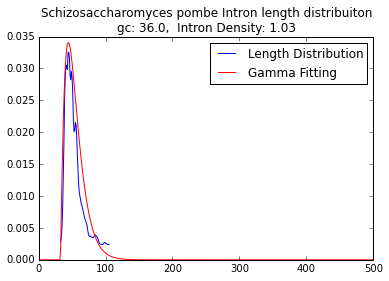

In [83]:
## updated intron distribution
fit_and_compare1('Schpo1',accProb = .8, distriType = 'INTRON',size = 10000, demo = True, exon_type="Intron")

      position    probability
2976      2996  1.926957e-128
2977      2997  1.744965e-128
2978      2998  1.580160e-128
2979      2999  1.430921e-128
2980      3000  1.295776e-128


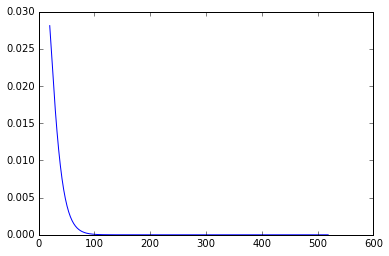

In [84]:
shape = 2.18
scale = 10.04
filepath = '/home/richard/research/1_DataSmall/heuristic_model_params/intron_length_distr/IntronDistr.txt'
getExonLengthEmissionDistribution1('INTRON',shape,scale,filepath, visualCheck = True)

shape = 2.72053343877, scale = 2.00604911576
max position:  8


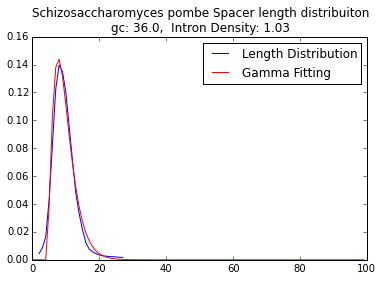

In [63]:
fit_and_compare('Schpo1',accProb = .99, distriType = 'BP_ACC',size = 10000, demo = True, exon_type="Spacer")

    position   probability
34        36  6.997427e-07
35        37  4.448953e-07
36        38  2.825084e-07
37        39  1.791791e-07
38        40  1.135147e-07


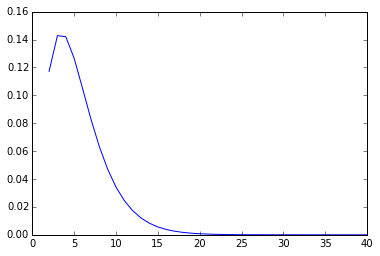

In [87]:
shape = 2.72
scale = 2.00
filepath = '/home/richard/research/1_DataSmall/heuristic_model_params/intron_length_distr/SpacerDistr.txt'
getExonLengthEmissionDistribution1('BP_ACC',shape,scale,filepath, visualCheck = True)

shape = 5.5298674341, scale = 4.79308782881
max position:  24


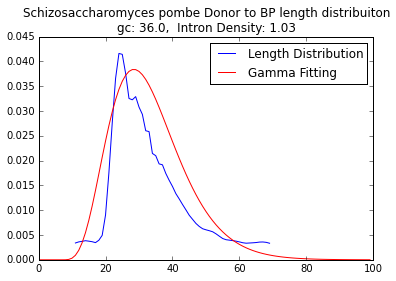

In [72]:
fit_and_compare('Schpo1',accProb = .75, distriType = 'DON_BP',size = 10000, demo = True, exon_type="Donor to BP")

      position    probability
2991      2996  3.513050e-262
2992      2997  2.855418e-262
2993      2998  2.320891e-262
2994      2999  1.886425e-262
2995      3000  1.533290e-262


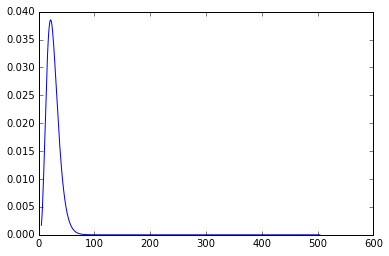

In [88]:
shape = 5.5
scale = 4.79
filepath = '/home/richard/research/1_DataSmall/heuristic_model_params/intron_length_distr/DonorToBPDistr.txt'
getExonLengthEmissionDistribution1('DON_BP',shape,scale,filepath, visualCheck = True)